In [1]:
import glob 
from skimage import io 
import matplotlib.pyplot as plt  
from splinter import Browser
from bs4 import BeautifulSoup as soup
from webdriver_manager.chrome import ChromeDriverManager # brew install chromedriver
import pandas as pd
from os.path  import basename
import requests
import base64
import os
import random
import numpy as np
import time

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder

## Scrape Produce Data
### Get Produce Names

In [3]:
executable_path = {'executable_path': ChromeDriverManager().install()} # webdriver to automate chrome
browser = Browser('chrome', **executable_path, headless=False)

# visit fruits and vegitables website
browser.visit('https://fruitsandveggies.org/stories/fruit-and-veggie-color-list/')
fruitnveg_soup = soup(browser.html, 'html.parser') # convert to soup object
produce = fruitnveg_soup.table.find_all('a') # find all fruits and vegetables
for item in range(len(produce)): # extract names from soup object
    produce[item] = produce[item].get_text() # add current item to list

print('There are '+str(len(produce))+' Produce items considered')   
print(produce[:5])

There are 121 Produce items considered
['Red Apples', 'Blood Oranges', 'Cherries', 'Cranberries', 'Red Grapes']


In [4]:
produce = produce[:2]

### Get Produce Pictures

In [5]:
def download_images(links, name, dirname, j):    
    png_array=  links
    png_array = png_array.split(",")
    png_array = png_array[1].encode()
    pathImg = dirname+'/'+name+str(j)+'.png'
    fh = open(pathImg, "wb")
    fh.write(base64.decodebytes(png_array))
    fh.close()

produce_table = {'nameId':[],'name':[],'width':[],'height':[],'encodedPic':[]} # Initialize DataFrame
for item in produce:
    if item != '': # If item is not null
        item = item.replace(' ','_') # Clean name
        image_path = 'Pictures/'+item
        try:
            os.mkdir(image_path) # Create directory to hold fruit-pics
        except:
            print('Directory Exists')

        home = 'https://images.google.com/' # Define 'Homepage'
        browser.visit(home) # Go to google
        time.sleep(random.random()*random.randint(1,6)) # Randomization, avoids chromes CAPTCHA
        browser.find_by_xpath( # Fill item
            '/html/body/div[1]/div[3]/form/div[1]/div[1]/div[1]/div/div[2]/input'
        ).fill(item)
        time.sleep(random.random()*random.randint(1,3))
        browser.find_by_xpath( # Click search button
            '/html/body/div[1]/div[3]/form/div[1]/div[1]/div[1]/button'
        ).click()

        Picture_soup = soup(browser.html, 'html.parser') # Convert Item Image Page to Soup
        Produce_Item_Images = Picture_soup.find_all('img') # Get all Images of Item
        j=0 # initailize counter
        for i in range(len(Produce_Item_Images)): # Download top images
            if Produce_Item_Images[i].get('data-deferred') == '1': # If top images
                lnk = Produce_Item_Images[i].get('src') # Get src
                try:
                    download_images(lnk, item, image_path, j) # Download image with unique naming
                    new_image_path = image_path+'/'+item+str(j)+'.png'
                    get_encoding = glob.glob(new_image_path)
                    image = io.imread(get_encoding[0]) # Encode Image in RGB
                    width = len(image)
                    height = len(image[0])
                    if width != 100 and height != 100: # If not square Image
                        middle_width = width//2 # Crop based on center
                        middle_height = height//2
                        image = image[middle_width-50:middle_width+50,middle_height-50:middle_height+50]
                    if type(image) != None:
                        produce_table['nameId'].append(new_image_path) # Add attributes to DataFrame
                        produce_table['name'].append(item) 
                        produce_table['width'].append(len(image[0])) # Double check images were cropped
                        produce_table['height'].append(len(image)) 
                        produce_table['encodedPic'].append(image)            
                        
                except:
                    status = 'nah'
                    
                j += 1

raw_produce = pd.DataFrame(produce_table)
raw_produce.head()

Directory Exists
Directory Exists


,nameId,name,width,height,encodedPic
0,Pictures/Red_Apples/Red_Apples0.png,Red_Apples,100,100,"[[[255, 255, 255, 255], [254, 254, 254, 255], ..."
1,Pictures/Red_Apples/Red_Apples1.png,Red_Apples,100,100,"[[[110, 109, 123], [109, 108, 122], [107, 106,..."
2,Pictures/Red_Apples/Red_Apples2.png,Red_Apples,100,100,"[[[255, 254, 255], [255, 255, 255], [255, 255,..."
3,Pictures/Red_Apples/Red_Apples3.png,Red_Apples,100,100,"[[[255, 255, 255], [255, 255, 255], [255, 254,..."
4,Pictures/Red_Apples/Red_Apples4.png,Red_Apples,100,100,"[[[209, 209, 209], [209, 209, 209], [209, 209,..."


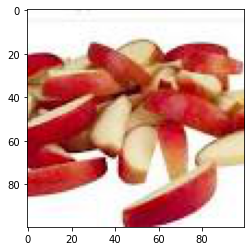

In [6]:
image = raw_produce['encodedPic'][8]
i, (im1) = plt.subplots(1)
i.set_figwidth(15)
im1.imshow(image)

### Preprocess Image

In [7]:
cleaned_images = {'name':raw_produce['name']}
for picture in range(len(raw_produce['encodedPic'])):
    current_picture = raw_produce['encodedPic'][picture]
    for k in range(3): # Split by 3 channels R,G,B
        channel = 'R' if k==0 else 'G' if k==1 else 'B'
        for i in range(100): # Split width of image
            for j in range(100): # Split height of image
                item = f'{channel} encodedPic ({i},{j})' # Name cleaned pixel feature
                try: # If 3 channel
                    pixel_code = current_picture[i][j][k]
                except: # If single channel                    
                    pixel_code = np.nan
                try: # If item has been hashed
                    cleaned_images[item].append(pixel_code)
                except:
                    cleaned_images[item] = [pixel_code]              

In [8]:
cleaned_images = pd.DataFrame(cleaned_images)
cleaned_images

,name,"R encodedPic (0,0)","R encodedPic (0,1)","R encodedPic (0,2)","R encodedPic (0,3)","R encodedPic (0,4)","R encodedPic (0,5)","R encodedPic (0,6)","R encodedPic (0,7)","R encodedPic (0,8)",...,"B encodedPic (99,90)","B encodedPic (99,91)","B encodedPic (99,92)","B encodedPic (99,93)","B encodedPic (99,94)","B encodedPic (99,95)","B encodedPic (99,96)","B encodedPic (99,97)","B encodedPic (99,98)","B encodedPic (99,99)"
0,Red_Apples,-1,-2,-2,-2,-2,-1,-7,-20,-19,...,-11,-11,-14,-7,-7,-7,-7,-7,-7,-7
1,Red_Apples,110,109,107,106,105,105,106,106,116,...,77,92,72,81,75,78,84,83,81,80
2,Red_Apples,-1,-1,-1,-1,-1,-1,-1,-2,-2,...,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2
3,Red_Apples,-1,-1,-1,-1,-1,-1,-1,-1,-9,...,-6,-8,-6,-3,-1,-1,-1,-1,-1,-1
4,Red_Apples,-47,-47,-47,-47,-47,-47,-47,-47,-46,...,-72,-72,-72,-72,-72,-72,-74,-74,-74,-74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Blood_Oranges,-52,-68,-5,-99,-62,-84,-51,-52,-82,...,62,77,86,97,-81,-42,-1,-38,-19,-16
60,Blood_Oranges,-33,-20,-35,-28,-8,-21,-25,-1,-15,...,-86,-81,-107,-119,122,110,73,15,40,45
61,Blood_Oranges,-121,105,-123,-99,-108,124,94,-122,-90,...,0,0,0,20,29,0,0,0,0,0
62,Blood_Oranges,-17,-18,-12,-9,-25,-21,-19,-15,-13,...,35,37,52,31,35,15,0,12,62,75


In [9]:
# Split our preprocessed data into our features and target arrays
y = cleaned_images['name']
X = cleaned_images.drop('name',1)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state= 42 ,stratify = y)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

/var/folders/2w/9nbxjyl94ds7lmb56xcp0vd00000gn/T/ipykernel_6028/242474054.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = cleaned_images.drop('name',1)
